In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# !pip install -q tensorflow-datasets
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.3.0


In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [41]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


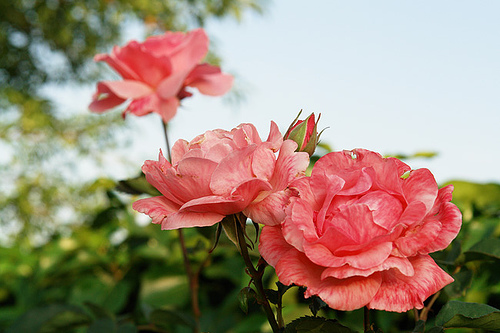

In [17]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

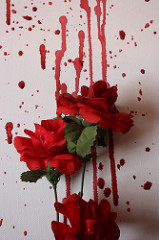

In [18]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))



In [5]:
batch_size = 32
img_height = 180
img_width = 180



In [8]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size
)

val_ds=tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size
)



Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


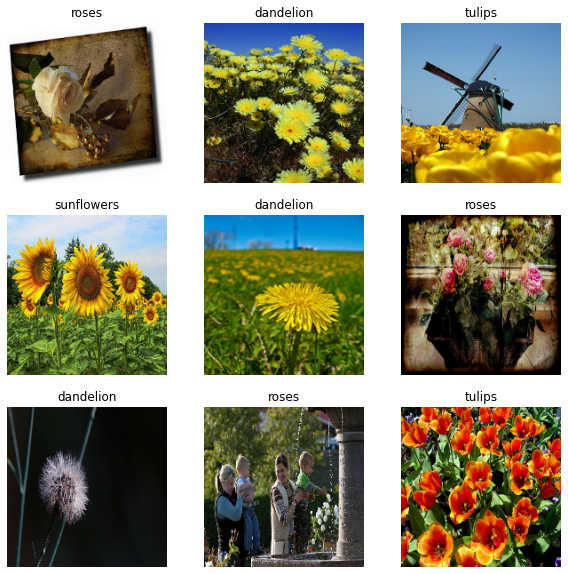

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [24]:
from tensorflow.keras import layers
normalization_layer=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)



In [25]:
normalized_ds=train_ds.map(lambda x,y:(normalization_layer(x),y)) # keras的layers们吃的都是一个batch的数据
image_batch,labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]
print(first_image)


tf.Tensor(
[[[3.26797389e-03 1.65795207e-01 2.54175771e-04]
  [7.73420697e-03 2.72004366e-01 3.92156886e-03]
  [5.64270243e-02 3.13870728e-01 1.01670169e-03]
  ...
  [1.15469741e-02 1.34204656e-01 6.17272977e-04]
  [3.25709768e-02 1.13725342e-01 0.00000000e+00]
  [4.61873822e-02 8.25707614e-02 3.44954384e-03]]

 [[1.19825709e-03 1.59803927e-01 3.15904175e-03]
  [6.86274702e-03 2.65686303e-01 3.26797570e-04]
  [5.67538254e-02 3.16666692e-01 1.96078443e-03]
  ...
  [4.35743155e-03 1.40631646e-01 1.85181876e-03]
  [2.48367619e-02 1.19934507e-01 0.00000000e+00]
  [3.88889126e-02 9.35729444e-02 9.91288759e-03]]

 [[3.66739347e-03 1.57080621e-01 7.33478693e-03]
  [1.30718984e-02 2.62091488e-01 0.00000000e+00]
  [6.07117042e-02 3.16376209e-01 0.00000000e+00]
  ...
  [3.15900892e-03 1.49963394e-01 6.17273012e-03]
  [5.66453952e-03 1.20152354e-01 0.00000000e+00]
  [1.12563567e-02 8.82352516e-02 7.11693801e-03]]

 ...

 [[2.73419935e-02 3.86710227e-01 7.62550626e-04]
  [0.00000000e+00 4.11111087

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

NameError: name 'train_ds' is not defined

In [27]:
num_classes=5
model=tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32,3,activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,3,activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32,3,activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128,activation='relu'),
  layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)


In [28]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 27s 293ms/step - loss: 1.3003 - accuracy: 0.4540 - val_loss: 1.1288 - val_accuracy: 0.5572

In [29]:
model.summary() #这个model需要fit之后才能summary因为输入层的数据形状未定

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

In [10]:
#一下是dataset

list_ds=tf.data.Dataset.list_files(str(data_dir/"*/*"),shuffle=False)
print(list_ds)
for f in list_ds.take(2):
  print(f) # 就是各个图片的路径
list_ds=list_ds.shuffle(image_count,reshuffle_each_iteration=False)

<TensorSliceDataset shapes: (), types: tf.string>
tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg', shape=(), dtype=string)


In [11]:
for f in list_ds.take(5):
  print(f.numpy())
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

b'/root/.keras/datasets/flower_photos/daisy/4276898893_609d11db8b.jpg'
b'/root/.keras/datasets/flower_photos/tulips/9870557734_88eb3b9e3b_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/5891485349_cce7b99549.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4271193206_666ef60aa0_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/200557983_10a88672fc.jpg'
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [12]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [13]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [14]:
def get_label(file_path):
  parts=tf.strings.split(file_path,os.path.sep)
  one_hot=parts[-2]==class_names
  return tf.argmax(one_hot)
def decode_img(img):
  img=tf.image.decode_jpeg(img,channels=3)
  return tf.image.resize(img,[img_height,img_width])
def process_path(file_path):
  label=get_label(file_path)
  img=tf.io.read_file(file_path)
  img=decode_img(img)
  return img,label

train_ds=train_ds.map(process_path,num_parallel_calls=AUTOTUNE)
val_ds=val_ds.map(process_path,num_parallel_calls=AUTOTUNE)
for image,label in train_ds.take(1):
  print("image shape:",image.numpy().shape)
  print("label: ",label.numpy())


image shape: (180, 180, 3)
label:  4


In [15]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

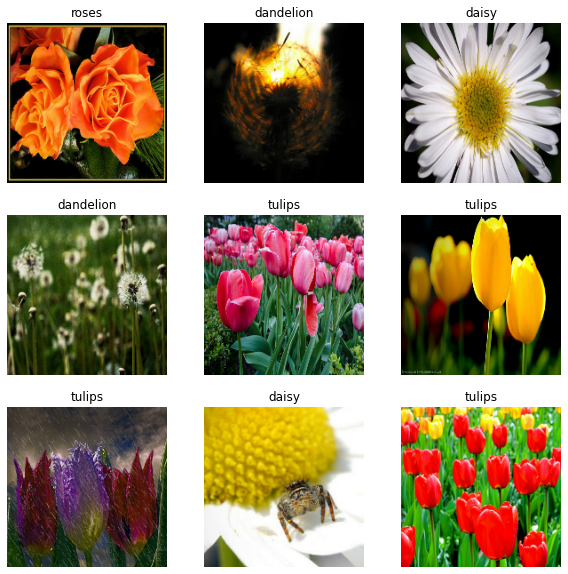

In [17]:
import matplotlib.pyplot as plt
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [19]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



In [20]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


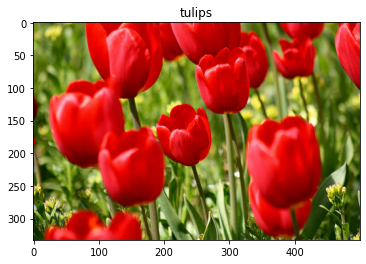

In [21]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))